# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_TO_TRAIN_DATA = '/content/drive/My Drive/Deep Learning/hw3/train.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from IPython.display import clear_output

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
words = stopwords.words('english')

In [ ]:
stemmer = SnowballStemmer('english')

In [ ]:
def process_text(text):
    return [stemmer.stem(word) for word in word_tokenize(text.lower()) if word not in string.punctuation and word not in words]

In [ ]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [ ]:
df_train, df_test = train_test_split(df, random_state=6)

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [ ]:
full_train = [' '.join(i) + ' ' + ' '.join(j) for i,j in zip(df_train['negative'], df_train['positive'])]
full_test = [' '.join(i) + ' ' + ' '.join(j) for i,j in zip(df_test['negative'], df_test['positive'])]

In [ ]:
tfidf_full = TfidfVectorizer()

In [ ]:
full_train = tfidf_full.fit_transform(full_train)
full_test = tfidf_full.transform(full_test)

In [ ]:
lr = LinearRegression(normalize=True)
lr.fit(full_train, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
mae(df_test['score'], lr.predict(full_test))

1.011768504447023

In [ ]:
pos_train = [' '.join(i) for i in df_train['positive']]
neg_train = [' '.join(i) for i in df_train['negative']]
pos_test = [' '.join(i) for i in df_test['positive']]
neg_test = [' '.join(i) for i in df_test['negative']]
tfidf_pos = TfidfVectorizer()
tfidf_neg = TfidfVectorizer()
pos_train = tfidf_pos.fit_transform(pos_train)
neg_train = tfidf_neg.fit_transform(neg_train)
pos_test = tfidf_pos.transform(pos_test)
neg_test = tfidf_neg.transform(neg_test)

In [ ]:
lr_pos = LinearRegression()
lr_neg = LinearRegression()
lr_neg.fit(neg_train, df_train['score'])
lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test))

0.989444081578944

In [ ]:
lr_pos = LinearRegression()
lr_neg = LinearRegression()
lr_neg.fit(neg_train, df_train['score'])
lr_pos.fit(pos_train, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mae(df_test['score'], 0.4*lr_pos.predict(pos_test) + 0.6*lr_neg.predict(neg_test))

0.9349482706864166

In [ ]:
mae(df_test['score'], lr_pos.predict(pos_test))

1.1132716985765914

In [ ]:
mae(df_test['score'], lr_neg.predict(neg_test))

1.012242507332592

In [ ]:
from scipy.sparse import hstack

In [ ]:
train_stack = hstack((neg_train, pos_train))
test_stack = hstack((neg_test, pos_test))

In [ ]:
lr_stack = LinearRegression(normalize=True)
lr_stack.fit(train_stack, df_train['score'])
mae(df_test['score'], lr_stack.predict(test_stack))

1.0017740003935154

### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
corpus = list(df_train['negative'].append(df_train['positive']))

In [ ]:
w2v = Word2Vec(min_count=5, workers=2, negative=10)

In [ ]:
w2v.build_vocab(corpus)

In [ ]:
w2v.train(sentences=corpus, total_examples=w2v.corpus_count, epochs=20)

(22357539, 28356240)

In [ ]:
wv = w2v.wv

In [ ]:
def text_to_vec(text, emb_size, wv):
    out = np.array([wv[word] for word in text if word in wv.vocab]).mean(axis=0)
    if isinstance(out, np.ndarray):
        return out
    return np.zeros(emb_size)

In [ ]:
neg_train = np.array([text_to_vec(text,100, wv) for text in df_train['negative']])
pos_train = np.array([text_to_vec(text,100, wv) for text in df_train['positive']])
neg_test = np.array([text_to_vec(text,100, wv) for text in df_test['negative']])
pos_test = np.array([text_to_vec(text,100, wv) for text in df_test['positive']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
lr_pos = LinearRegression()
lr_neg = LinearRegression()
lr_neg.fit(neg_train, df_train['score'])
lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test))

0.9540547803323565

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit([' '.join(i) for i in df_train['negative'].append(df_train['positive'])])
idf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
def text_to_vec_idf(text, emb_size):
    vecs = np.array([w2v[word] * idf[word] for word in text if word in wv.vocab and word in idf.keys()]).sum(axis=0)
    sum_idf = sum([idf[word] for word in text if word in idf.keys()])
    if isinstance(vecs, np.ndarray):
        return vecs/sum_idf
    return np.zeros(emb_size)

In [ ]:
neg_train = np.array([text_to_vec_idf(text,100) for text in df_train['negative']])
pos_train = np.array([text_to_vec_idf(text,100) for text in df_train['positive']])
neg_test = np.array([text_to_vec_idf(text,100) for text in df_test['negative']])
pos_test = np.array([text_to_vec_idf(text,100) for text in df_test['positive']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
lr_pos = LinearRegression()
lr_neg = LinearRegression()
lr_neg.fit(neg_train, df_train['score'])
lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test))

0.9621141183052774

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
quals_normal = []
for emb_size in tqdm(np.arange(20, 300, 10)):
    w2v = Word2Vec(min_count=5, workers=2, negative=10, size=emb_size)
    w2v.build_vocab(corpus)
    w2v.train(sentences=corpus, total_examples=w2v.corpus_count, epochs=20)
    neg_train = np.array([text_to_vec(text, emb_size, wv) for text in df_train['negative']])
    pos_train = np.array([text_to_vec(text, emb_size, wv) for text in df_train['positive']])
    neg_test = np.array([text_to_vec(text, emb_size, wv) for text in df_test['negative']])
    pos_test = np.array([text_to_vec(text, emb_size, wv) for text in df_test['positive']])
    lr_pos = LinearRegression()
    lr_neg = LinearRegression()
    lr_neg.fit(neg_train, df_train['score'])
    lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))
    quals_normal.append(mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 

In [ ]:
quals_idf = []
for emb_size in tqdm(np.arange(20, 300, 10)):
    w2v = Word2Vec(min_count=5, workers=2, negative=10, size=emb_size)
    w2v.build_vocab(corpus)
    w2v.train(sentences=corpus, total_examples=w2v.corpus_count, epochs=20)
    neg_train = np.array([text_to_vec_idf(text, emb_size) for text in df_train['negative']])
    pos_train = np.array([text_to_vec_idf(text, emb_size) for text in df_train['positive']])
    neg_test = np.array([text_to_vec_idf(text, emb_size) for text in df_test['negative']])
    pos_test = np.array([text_to_vec_idf(text, emb_size) for text in df_test['positive']])
    lr_pos = LinearRegression()
    lr_neg = LinearRegression()
    lr_neg.fit(neg_train, df_train['score'])
    lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))
    quals_normal.append(mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_l

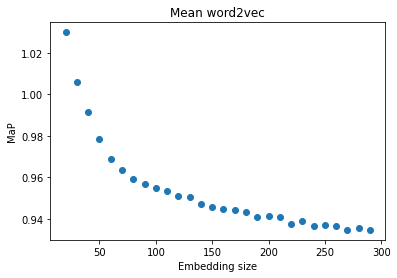

In [ ]:
plt.scatter(np.arange(20, 300, 10), quals_normal[:28])
plt.title('Mean word2vec')
plt.xlabel('Embedding size')
plt.ylabel('MaP')
plt.show()

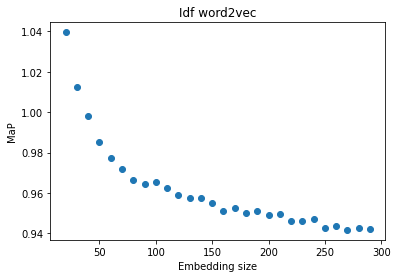

In [ ]:
plt.scatter(np.arange(20, 300, 10), quals_normal[28:])
plt.title('Idf word2vec')
plt.xlabel('Embedding size')
plt.ylabel('MaP')
plt.show()

Обычное усреднение лучше усреднения с IDF для любой размерности векторов. Возможно, именно слова которые встречаются чаще, лучше отражают тональность текста. При этом с ростом размерности растет и качество модели, есть небольшие отклонения, но в целом это верно для всех размерностей от 20 до 300. 

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы:

In [ ]:
w2v = Word2Vec(size=300, min_count=5, negative=10, workers=2)
w2v.build_vocab(corpus)
w2v.train(sentences=corpus, total_examples=w2v.corpus_count, epochs=20, compute_loss=True)

(22357811, 28356240)

In [ ]:
neg_train = np.array([text_to_vec(text,300, wv) for text in df_train['negative']])
pos_train = np.array([text_to_vec(text,300, wv) for text in df_train['positive']])
neg_test = np.array([text_to_vec(text,300, wv) for text in df_test['negative']])
pos_test = np.array([text_to_vec(text,300, wv) for text in df_test['positive']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
lr_pos = LinearRegression(normalize=True)
lr_neg = LinearRegression(normalize=True)
lr_neg.fit(neg_train, df_train['score'])
lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test))

0.9347576531430619

In [ ]:
from gensim.models import FastText 

In [ ]:
fasttext = FastText(size=300, negative=10, workers=2)

In [ ]:
fasttext.build_vocab(corpus)
fasttext.train(sentences=corpus, total_examples=fasttext.corpus_count, epochs=20)

In [ ]:
wv = fasttext.wv

In [ ]:
neg_train = np.array([text_to_vec(text,300, wv) for text in df_train['negative']])
pos_train = np.array([text_to_vec(text,300, wv) for text in df_train['positive']])
neg_test = np.array([text_to_vec(text,300, wv) for text in df_test['negative']])
pos_test = np.array([text_to_vec(text,300, wv) for text in df_test['positive']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
lr_pos = LinearRegression(normalize=True)
lr_neg = LinearRegression(normalize=True)
lr_neg.fit(neg_train, df_train['score'])
lr_pos.fit(pos_train, df_train['score'] - lr_neg.predict(neg_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
mae(df_test['score'], lr_pos.predict(pos_test) + lr_neg.predict(neg_test))

0.9341009130929993

Fasttext показал результат немного лучше W2V, то есть выучил примерно столько же информации из текста

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence

In [ ]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [ ]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [ ]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = torch.zeros((torch.prod(torch.tensor(arr.shape)), n_labels))
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [ ]:
df_train['full'] = df_train['positive'] + df_train['negative']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train['full'] = df_train['positive'] + df_train['negative']
df_test['full'] = df_test['positive'] + df_test['negative']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['len'] = df['positive'].apply(len) + df['negative'].apply(len)

In [ ]:
df['len'] = df['positive'].apply(len) + df['negative'].apply(len)
MAXLEN = int(df['len'].quantile(0.75))

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAXLEN]) for seq in df['full']], 
                           batch_first=True)
        self.answers = list(df['score'])
        
    def __len__(self):
        return len(self.answers)
        
    
    def __getitem__(self, idx):
        return (one_hot_encode(self.data[idx, :], len(WORDS)), self.answers[idx])

In [ ]:
BATCH_SIZE = 16

train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
class RNN(nn.Module):
    def __init__(self, num_layers=4, hidden_size=256, input_size=len(WORDS), drop=0.5):

        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):

        out, (ht, ct) = self.lstm(x)
        return self.linear(self.dropout(ht[-1]))

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, train_loss, id, scheduler, device="cuda:0"):
    model.train()

    i = 0
    for data, answers in tqdm(train_dataloader):

            data = data.to(device)
            answers = answers.to(device)

            optimizer.zero_grad()
            pred = model(data).view(-1)
            loss = criterion(pred, answers) 
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            train_loss.append(loss.item())

            i += 1
            if i % 100 == 0:
                print(f'Train loss: {np.mean(train_loss[-500:])}' )

    return train_loss
    

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    epoch_loss = []
    predictions = []
    real_classes = []

    with torch.no_grad():
        
        for data, answers in tqdm(val_dataloader):

            data = data.to(device)
            answers = answers.to(device)

            pred = model(data).view(-1)     
            predictions.append(pred)
            real_classes.append(answers)

    
    predictions = [i for j in predictions for i in j]
    real_classes = [i for j in real_classes for i in j]


    return criterion(torch.tensor(real_classes), torch.tensor(predictions)).item(), real_classes, predictions

def draw(train_loss, val_loss,  batch_size, epoch):
    clear_output()
    plt.figure()
    plt.scatter(np.arange(1, len(train_loss) + 1), train_loss, label='train', color='blue', zorder=1)
    plt.scatter(np.arange(1, epoch+2) * batch_size, val_loss, color='red', label='val', zorder=2)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    print(f'epoch: {epoch}')
    

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None, id=None, batch_size=1563):
    model.to(device)
    train_loss = []
    val_loss = []

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, train_loss, id, scheduler, device)
        val_epoch_loss, answers, pred = predict(model, val_dataloader, criterion, device)
        val_loss.append(val_epoch_loss)

        if scheduler:
            scheduler.step(val_loss[-1])

        draw(train_loss, val_loss, batch_size, epoch)
        print(f'Last val loss: {val_loss[-1]}, best val loss: {min(val_loss)}')
        print(f'Sklearn loss: {mae(answers, pred)}')

    print(f'{id} Training done')
    print(f'Vall loss: {val_loss[-1]}')


In [ ]:
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
n_epochs = 4
device = torch.device('cuda:0')

In [ ]:
model = model.to('cuda:0')

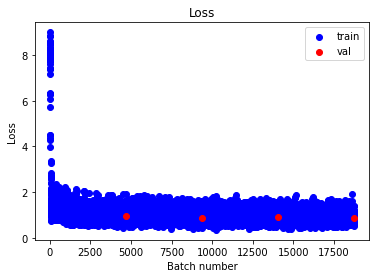

epoch: 3
Last val loss: 0.87498568359375, best val loss: 0.87498568359375
Sklearn loss: 0.8749856835937498
None Training done
Vall loss: 0.87498568359375


In [ ]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, n_epochs=n_epochs, batch_size=4688)

In [ ]:
l, answers, pred = predict(model, test_dataloader, criterion)

In [ ]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    w2v.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    #new_model = gensim.models.Word2Vec.load(temporary_filepath)

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.

In [ ]:
from gensim.models import Word2Vec

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, train_loss, id, scheduler, device, h):
    model.train()

    i = 0
    for data, answers in tqdm(train_dataloader):

            h = tuple([each.data for each in h])

            data = data.to(device)
            answers = answers.to(device)
            try:
                optimizer.zero_grad()
                pred = model(data, h).view(-1)
                loss = criterion(pred, answers) 
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5)
                optimizer.step()

                train_loss.append(loss.item())
            except:
                print('ooops')

            i += 1
            if i % 500 == 0:
                print(f'Train loss: {np.mean(train_loss[-500:])}' )

    return train_loss
    

def predict(model, val_dataloader, criterion, h, device="cuda:0"):
    model.eval()
    epoch_loss = []
    predictions = []
    real_classes = []

    with torch.no_grad():
        
        for data, answers in tqdm(val_dataloader):

            data = data.to(device)
            answers = answers.to(device)

            pred = model(data, h).view(-1)     
            predictions.append(pred)
            real_classes.append(answers)

    
    predictions = [i for j in predictions for i in j]
    real_classes = [i for j in real_classes for i in j]


    return criterion(torch.tensor(real_classes), torch.tensor(predictions)).item(), real_classes, predictions

def draw(train_loss, val_loss,  batch_size, epoch):
    clear_output()
    plt.figure()
    plt.scatter(np.arange(1, len(train_loss) + 1), train_loss, label='train', color='blue', zorder=1)
    plt.scatter(np.arange(1, epoch+2) * batch_size, val_loss, color='red', label='val', zorder=2)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    print(f'epoch: {epoch}')
    

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None, id=None, batch_size=1563):
    model.to(device)
    train_loss = []
    val_loss = []

    for epoch in range(n_epochs):
        h = model.init_hidden(8)

        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, train_loss, id, scheduler, device, h=h)
        val_epoch_loss, answers, pred = predict(model, val_dataloader, criterion, h, device)
        val_loss.append(val_epoch_loss)

        if scheduler:
            scheduler.step(val_loss[-1])

        draw(train_loss, val_loss, batch_size, epoch)
        print(f'Last val loss: {val_loss[-1]}, best val loss: {min(val_loss)}')
        print(f'Sklearn loss: {mae(answers, pred)}')

    print(f'{id} Training done')
    print(f'Vall loss: {val_loss[-1]}')


In [ ]:
class RNN(nn.Module):
    def __init__(self, num_layers=4, hidden_size=256, input_size=300, drop=0.5):

        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        self.emb = nn.Embedding(21783, 300)
        self.n_layers = num_layers
        self.n_hidden = hidden_size


    def forward(self, x, h):

        out, (ht, ct) = self.lstm(self.emb(x), h)
        return self.linear(self.dropout(ht[-1]))

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
              weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden

In [ ]:
class RNN_deep(nn.Module):
    def __init__(self, num_layers=4, hidden_size=256, input_size=300, drop=0.5):

        super().__init__()

        self.n_layers = num_layers
        self.n_hidden = hidden_size

        self.emb = nn.Embedding(21783, 300)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear1 =nn.Sequential(nn.Dropout(drop),
                                    nn.Linear(in_features=5*60*22, out_features=3000))
        self.linear2 = nn.Sequential(nn.Dropout(drop),
                                     nn.Linear(in_features=3000, out_features=1))
        self.relu = nn.ReLU()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,1), padding=0, dilation=1),
                                   nn.BatchNorm2d(1),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), padding=(1, 0), dilation=1),
                                   nn.BatchNorm2d(1),
                                   nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4,1), padding=(1, 0), dilation=1),
                                   nn.BatchNorm2d(1),
                                   nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,1), padding=(2, 0), dilation=1),
                                   nn.BatchNorm2d(1),
                                   nn.ReLU())

        self.pool = nn.MaxPool2d(kernel_size=(1, 4))

        self.conv = nn.Sequential(nn.Conv2d(in_channels=5, out_channels=5, kernel_size=(3, 5)),
                                  nn.BatchNorm2d(5),
                                  nn.ReLU())
      

    def forward(self, x, h):

        out, (ht, ct) = self.lstm(self.emb(x), h)
        out = out.unsqueeze(1)
        x1 = self.conv1(torch.cat((torch.zeros(out.shape[0], out.shape[1], 1, out.shape[3]).to('cuda:0'), out), dim=2))
        x2 = self.conv2(out)
        x3 = self.conv3(torch.cat((torch.zeros(out.shape[0], out.shape[1], 1, out.shape[3]).to('cuda:0'), out), dim=2))
        x4 = self.conv4(out)
        out1 = torch.cat((x1, x2, x3, x4, out), dim=1)
        out2 = nn.Flatten()(self.conv(self.pool(out1)))
        out3 = self.linear2(self.relu(self.linear1(out2)))
      
        return out3
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
              weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden

In [ ]:
corpus = list(df_train['negative'].append(df_train['positive']))
w2v = Word2Vec(min_count=1, workers=2, negative=10, size=300)
w2v.build_vocab(corpus)
w2v.train(sentences=corpus, total_examples=w2v.corpus_count, epochs=20)

(22876136, 28356240)

In [ ]:
WORDS = set()
for sent in list(df_train['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df_train['negative']):
    for w in sent:
        WORDS.add(w)

int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [ ]:
embeddings = torch.tensor([w2v.wv[int2word[idx]] for idx in tqdm(range(21782))])

In [ ]:
embeddings = torch.cat((embeddings, torch.zeros(1, 300)))

In [ ]:
df_train['full'] = df_train['positive'] + df_train['negative']
df_test['full'] = df_test['positive'] + df_test['negative']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['len'] = df['positive'].apply(len) + df['negative'].apply(len)
MAXLEN = int(df['len'].quantile(0.75))

In [ ]:
class ReviewsDataset_w2v(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = pad_sequence([torch.as_tensor([word2int[w] if w in word2int.keys() else 21782 for w in seq][:MAXLEN]) for seq in df['full']], 
                           batch_first=True, padding_value=21782)
        self.answers = list(df['score'])
        
    def __len__(self):
        return len(self.answers)
        
    
    def __getitem__(self, idx):
        return (self.data[idx, :], self.answers[idx])

BATCH_SIZE = 8

train_dataset = ReviewsDataset_w2v(df_train)
test_dataset = ReviewsDataset_w2v(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model = RNN_deep(input_size=300, num_layers=8)
model.emb = nn.Embedding.from_pretrained(embeddings)
model = model.to('cuda:0')
device = torch.device('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7)
n_epochs=20

In [ ]:
criterion = nn.L1Loss()

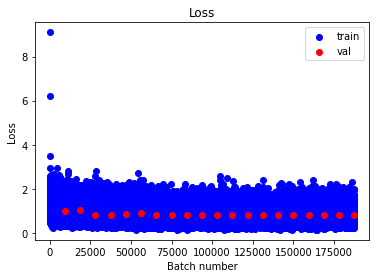

epoch: 19
Last val loss: 0.8108141116695404, best val loss: 0.807004930902481
Sklearn loss: 0.8108141116695404
None Training done
Vall loss: 0.8108141116695404


In [ ]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, n_epochs=n_epochs, scheduler=scheduler, batch_size=len(train_dataset)/8)